In [1]:
import numpy as np
from PIL import Image
import DataProvider
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import time
import seaborn as sns
from IPython import display

реализация U-Net c [Medium](https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f' Device: {torch.cuda.get_device_name(0)}. Now using: {device.type}', '\n',
      f'Torch Version: {torch.version.__version__}')

 Device: NVIDIA GeForce RTX 4070 Ti. Now using: cuda 
 Torch Version: 2.2.1


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

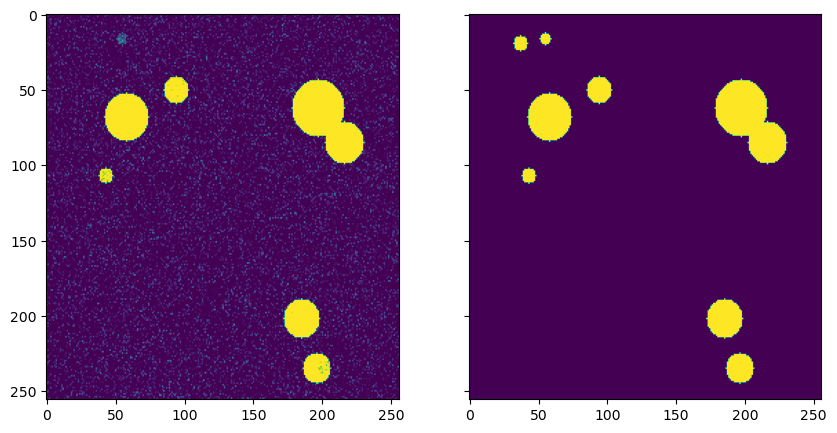

In [4]:
provider = DataProvider.RgbDataProvider(nx=256, 
                                        ny=256, 
                                        border=16, 
                                        r_min = 4, 
                                        r_max = 25)
X, Y = provider(8)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax[0].imshow(X[0,...,0], aspect="auto")
ax[1].imshow(Y[0,...,1], aspect="auto")

In [5]:
class CustomDataset(Dataset):
    def __init__(self, provider, size):
        self.provider = provider
        self.size = size

    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        
        X, Y = self.provider(self.size)
        x_tensor = torch.tensor(X).float().permute(0,3,1,2)
        y_tensor = torch.tensor(Y).float().permute(0,3,1,2)
        
        return x_tensor, y_tensor

In [6]:
batch_size = 16
dataset = CustomDataset(provider, size = batch_size)
dataloader = DataLoader(dataset)

In [7]:
model = UNet(3,2).to(device)
for x, y in dataloader:      
    x = x.to(device).squeeze(0)
    print(f'x: {x.shape}')
    y = y.to(device).squeeze(0)
    print(f'y: {y.shape}')
    output = model(x)
    print(f'out: {output.shape}')

x: torch.Size([16, 3, 256, 256])
y: torch.Size([16, 2, 256, 256])
out: torch.Size([16, 2, 256, 256])


In [8]:
model = UNet(3,2).to(device)
loss_func = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.0001, 
                             weight_decay=0.0001
                             )

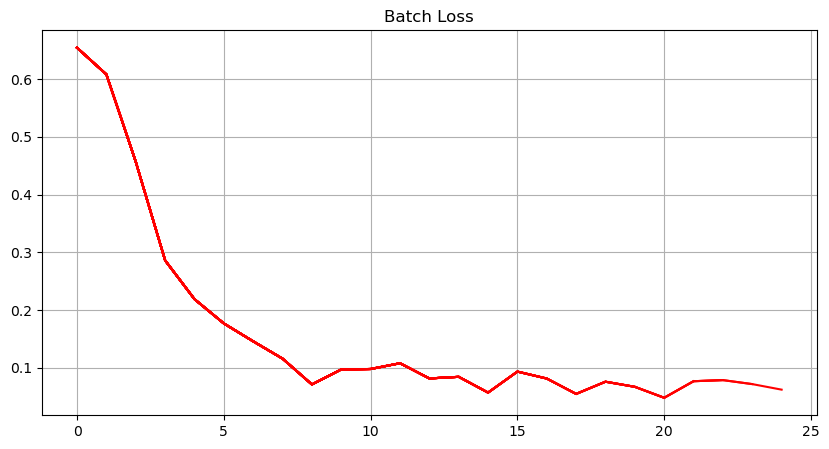

Iteration 250 -- Batch Loss: 0.0620 -- Time: 93.66s


In [9]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 5))
ax.set_title('Batch Loss')
ax.grid()

batch_size = 16
dataset = CustomDataset(provider, size = batch_size)
dataloader = DataLoader(dataset)

N_ITER = 250
model.to(device)
train_counter = 0
train_losses = []
total_time = 0
while train_counter <= N_ITER:
    model.train()
    start = time.time()
    train_loss = 0.
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device).squeeze(0)
        y_batch = y_batch.to(device).squeeze(0)
        output = model(x_batch)

        batch_loss = loss_func(output, y_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item() 
    train_counter +=1
    total_time += (time.time() - start)
    
    if train_counter % 10 == 0:
            train_losses.append(batch_loss.item())
            sns.lineplot(train_losses, c='red', ax=ax)
            display.display(fig, clear=True)
            plt.close()

            print(f'Iteration {train_counter} -- Batch Loss: {batch_loss:.4f} -- Time: {total_time:.2f}s')
    
    


Text(0.5, 1.0, 'Predicted Mask')

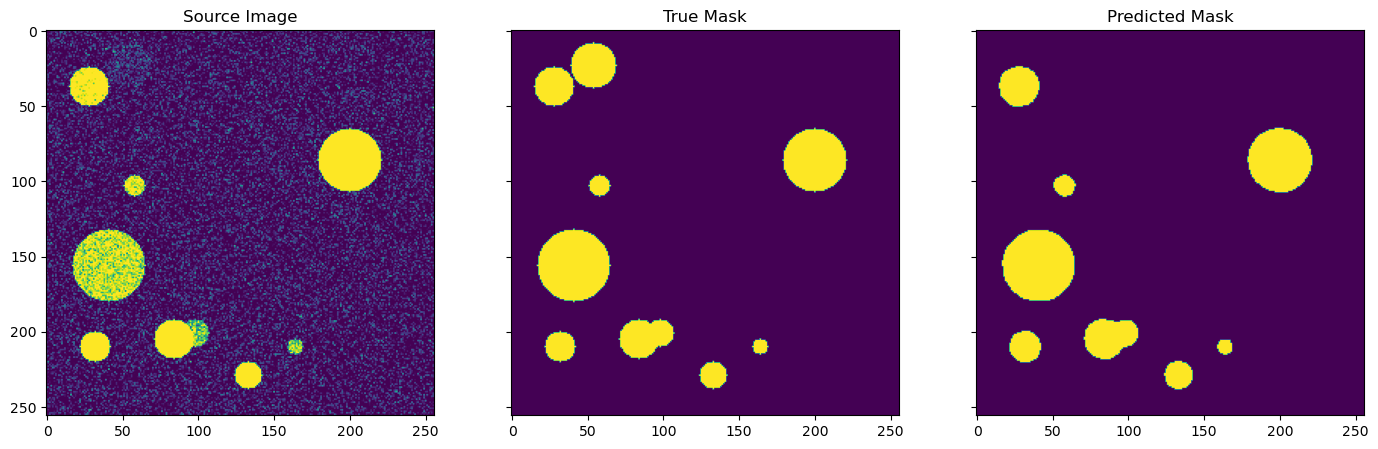

In [17]:
x_test, y_test = provider(1)
x_test_tensor = torch.tensor(x_test).permute(0,3,1,2).to(device).float()
with torch.no_grad():
    output = model(x_test_tensor).permute(0,2,3,1)
    predicted_mask = (torch.sigmoid(output) > 0.5).float().cpu().numpy()

fig, ax = plt.subplots(1,3, sharey=True, figsize=(17,5))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[2].imshow(predicted_mask[0,...,1], aspect="auto")
ax[0].set_title('Source Image')
ax[1].set_title('True Mask')
ax[2].set_title('Predicted Mask')